In [1]:
import sys
import argparse
import time
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

In [2]:
## image:

pano_img = cv2.imread("./data/image.jpg")

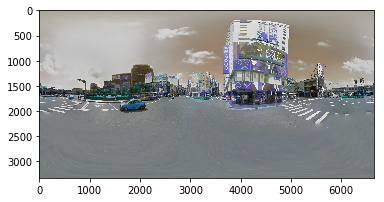

In [3]:
plt.imshow(pano_img)

In [43]:
pi = math.pi
inc = pi / 36
yaw = 0 * inc  # -pi < b < pi
pitch = 0 * inc  # -pi/2 < a < pi/2
roll = 0
rot = [yaw, pitch, roll]

fov_x = 60
pers_size = [480, 640]

## Using Pytorch

In [44]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image

In [45]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[[2, 1, 0]])
])

In [46]:
pano_w = pano_img.shape[1]
pano_h = pano_img.shape[0]

pers_w = pers_size[1]
pers_h = pers_size[0]

print(pano_img.shape)
print(pers_size)

(3328, 6656, 3)
[480, 640]


In [52]:
f = pers_w / (2 * np.tan(np.radians(fov_x) / 2))

K = torch.tensor([[f, 0, pers_w],
                  [0, f, pers_h],
                  [0, 0, 1]])
K_inv = K.inverse()
print(K)
print(K_inv)

tensor([[554.2563,   0.0000, 640.0000],
        [  0.0000, 554.2563, 480.0000],
        [  0.0000,   0.0000,   1.0000]])
tensor([[ 0.0018,  0.0000, -1.1547],
        [ 0.0000,  0.0018, -0.8660],
        [ 0.0000,  0.0000,  1.0000]])


In [82]:
_vi = torch.linspace(0, pers_w - 1, pers_w)
_vj = torch.linspace(0, pers_h - 1, pers_h)

vj, vi = torch.meshgrid([_vj, _vi])

print(vi.shape)
print(vj.shape)
print(vi[0].shape)

vk = torch.ones_like(vi)
coord = torch.stack((vi /f , vj / f, vk), dim=2)


print(coord.shape)
print(coord.unsqueeze(3).shape)
coord = coord.unsqueeze(3)

torch.Size([480, 640])
torch.Size([480, 640])
torch.Size([640])
torch.Size([480, 640, 3])
torch.Size([480, 640, 3, 1])


In [83]:
rot_yaw, rot_pitch, rot_roll = rot

R_yaw = [
    [np.cos(rot_yaw), 0, -np.sin(rot_yaw)],
    [0, 1, 0],
    [np.sin(rot_yaw), 0, np.cos(rot_yaw)]
]
R_pitch = [
    [1, 0, 0],
    [0, np.cos(rot_pitch), -np.sin(rot_pitch)],
    [0, np.sin(rot_pitch), np.cos(rot_pitch)]
]
R_roll = [
    [np.cos(rot_roll), -np.sin(rot_roll), 0],
    [np.sin(rot_roll), np.cos(rot_roll), 0],
    [0, 0, 1]
]
R = torch.Tensor(R_roll) @ torch.Tensor(R_pitch) @ torch.Tensor(R_yaw)

print(R.shape)
print(R)
sphere_coord = R  @ coord
print(sphere_coord.shape)
print(sphere_coord.squeeze(3).shape)
sphere_coord = sphere_coord.squeeze(3)

torch.Size([3, 3])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
torch.Size([480, 640, 3, 1])
torch.Size([480, 640, 3])


In [84]:
a = torch.atan2(sphere_coord[:, :, 0], sphere_coord[:, :, 2])
b = torch.asin(sphere_coord[:, :, 1] / torch.norm(sphere_coord, dim=2))

ui = (a + np.pi) * pano_w / (2 * np.pi)
uj = (b + np.pi / 2) * pano_h / np.pi
norm_ui = 2 * (ui - pano_w / 2) / pano_w
norm_uj = 2 * (uj - pano_h / 2) / pano_h

grid = torch.stack((norm_ui, norm_uj), 2).unsqueeze(0)
print(grid)

pano = trans(pano_img)


pano = pano.expand(grid.size(0), -1, -1, -1)

pers = torch.nn.functional.grid_sample(pano, grid).squeeze(0)
pers = pers.permute(1, 2, 0)

pers_img = pers.numpy()[..., [2,1,0]]

tensor([[[[0.0000, 0.0000],
          [0.0006, 0.0000],
          [0.0011, 0.0000],
          ...,
          [0.2721, 0.0000],
          [0.2723, 0.0000],
          [0.2726, 0.0000]],

         [[0.0000, 0.0011],
          [0.0006, 0.0011],
          [0.0011, 0.0011],
          ...,
          [0.2721, 0.0008],
          [0.2723, 0.0008],
          [0.2726, 0.0008]],

         [[0.0000, 0.0023],
          [0.0006, 0.0023],
          [0.0011, 0.0023],
          ...,
          [0.2721, 0.0015],
          [0.2723, 0.0015],
          [0.2726, 0.0015]],

         ...,

         [[0.0000, 0.4524],
          [0.0006, 0.4524],
          [0.0011, 0.4524],
          ...,
          [0.2721, 0.3274],
          [0.2723, 0.3271],
          [0.2726, 0.3269]],

         [[0.0000, 0.4531],
          [0.0006, 0.4531],
          [0.0011, 0.4531],
          ...,
          [0.2721, 0.3279],
          [0.2723, 0.3277],
          [0.2726, 0.3274]],

         [[0.0000, 0.4537],
          [0.0006, 0.4537],
    

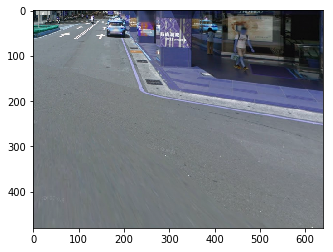

In [85]:
plt.imshow(pers_img)

In [115]:
f_x, f_y = [1, 1]
size = [480, 640]

v, u = torch.meshgrid([torch.linspace(-1, 1, s) for s in size])
u = u / f_x
v = v / f_y
w = torch.ones_like(u)
coord = torch.stack((u, v, w), dim=2)

R_yaw = [
    [np.cos(rot_yaw), 0, -np.sin(rot_yaw)],
    [0, 1, 0],
    [np.sin(rot_yaw), 0, np.cos(rot_yaw)]
]
R_pitch = [
    [1, 0, 0],
    [0, np.cos(rot_pitch), -np.sin(rot_pitch)],
    [0, np.sin(rot_pitch), np.cos(rot_pitch)]
]
R_roll = [
    [np.cos(rot_roll), -np.sin(rot_roll), 0],
    [np.sin(rot_roll), np.cos(rot_roll), 0],
    [0, 0, 1]
]
R = torch.Tensor(R_roll) @ torch.Tensor(R_pitch) @ torch.Tensor(R_yaw)

roted_coord = coord @ R

x_sin = roted_coord[:, :, 0] / torch.norm(roted_coord[:, :, [0, 2]], dim=2)
y_sin = roted_coord[:, :, 1] / torch.norm(roted_coord, dim=2)

x_raw = torch.asin(x_sin)
x_raw = torch.where(roted_coord[:, :, 2] < 0, np.pi - x_raw, x_raw)
y_raw = torch.asin(y_sin)

x = x_raw / np.pi
x = torch.remainder(x, 2) - 1
y = 2 * y_raw / np.pi

grid = torch.stack((x, y), 2).unsqueeze(0)
print(grid)

pano = trans(pano_img)
print(pano_img.shape)

pano = pano.expand(grid.size(0), -1, -1, -1)

pers = torch.nn.functional.grid_sample(pano, grid).squeeze(0)
pers = pers.permute(1, 2, 0)
pers_img = pers.numpy()[..., [2,1,0]]

tensor([[[[ 0.7500, -0.3918],
          [ 0.7505, -0.3923],
          [ 0.7510, -0.3928],
          ...,
          [-0.7510, -0.3928],
          [-0.7505, -0.3923],
          [-0.7500, -0.3918]],

         [[ 0.7500, -0.3906],
          [ 0.7505, -0.3910],
          [ 0.7510, -0.3915],
          ...,
          [-0.7510, -0.3915],
          [-0.7505, -0.3910],
          [-0.7500, -0.3906]],

         [[ 0.7500, -0.3893],
          [ 0.7505, -0.3898],
          [ 0.7510, -0.3903],
          ...,
          [-0.7510, -0.3903],
          [-0.7505, -0.3898],
          [-0.7500, -0.3893]],

         ...,

         [[ 0.7500,  0.3893],
          [ 0.7505,  0.3898],
          [ 0.7510,  0.3903],
          ...,
          [-0.7510,  0.3903],
          [-0.7505,  0.3898],
          [-0.7500,  0.3893]],

         [[ 0.7500,  0.3906],
          [ 0.7505,  0.3910],
          [ 0.7510,  0.3915],
          ...,
          [-0.7510,  0.3915],
          [-0.7505,  0.3910],
          [-0.7500,  0.3906]],



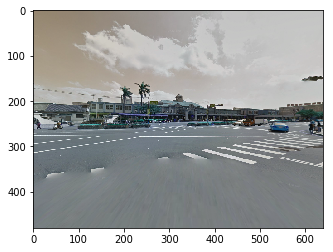

In [116]:
plt.imshow(pers_img)